<a href="https://colab.research.google.com/github/xDaryamo/BreastCancerPrediction/blob/master/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Visualization

In [502]:
import pandas as pd
import numpy as np
import os
import seaborn as sb
from matplotlib import style
import matplotlib.pyplot as plt
from numpy import set_printoptions

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression, mutual_info_classif, chi2
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, plot_confusion_matrix, classification_report

##1.1 Ottenimento del dataset




In [473]:
#link al file csv
csv = "https://raw.githubusercontent.com/xDaryamo/BreastCancerPrediction/master/dataset.csv"

#Caricamento del csv dalla repo GitHub
df = pd.read_csv(csv)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [474]:
#Informazioni aggiuntive sulle colonne
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [475]:
#Distribuzione dei dati
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [476]:
#Numeri delle colonne e delle righe del dataset
df.shape

(569, 33)

Notiamo che la colonna target "diagnosis" assume come valori:
M (Maligno) o B (Benigno).

Per semplificare l'analisi dei dati convertiamo i valori in:

*   (M)aligno -> 1
*   (B)enigno -> 0



In [477]:
df.diagnosis.replace({"M":1,"B":0},inplace=True)
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


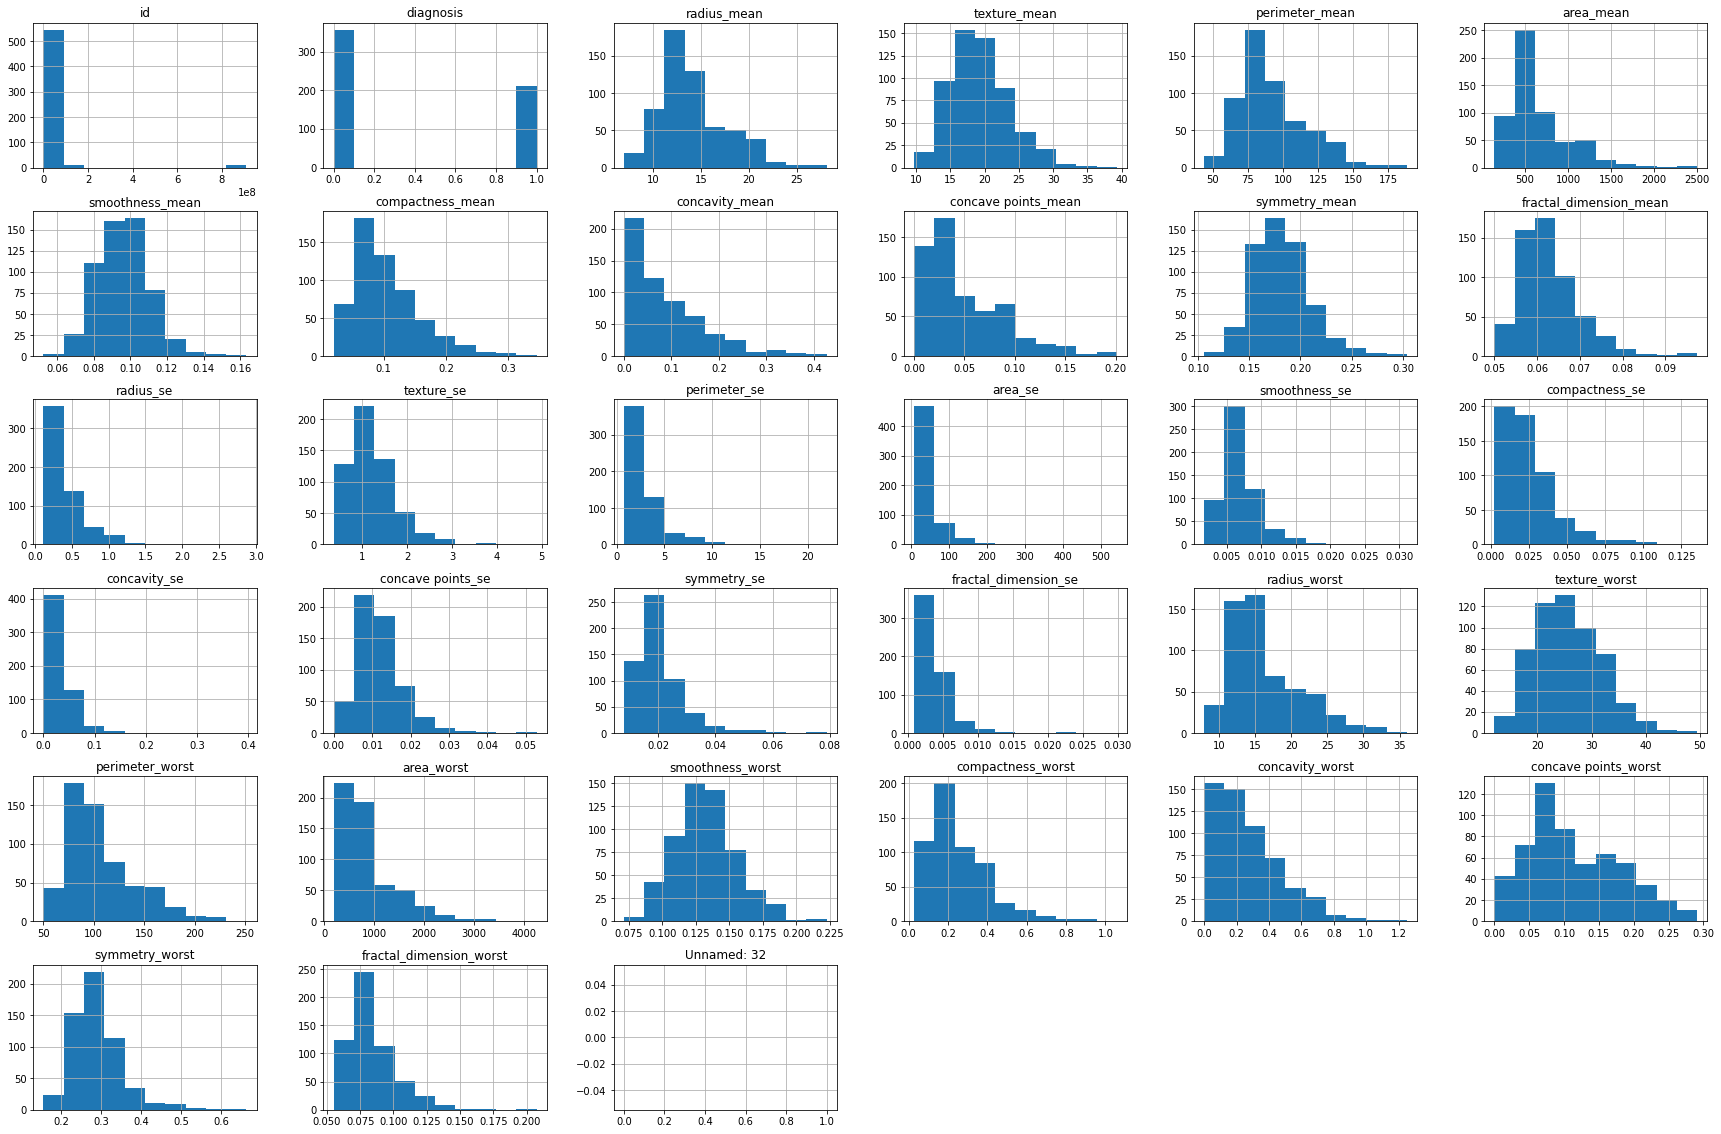

In [478]:
plt.rcParams['figure.figsize'] = (30,20)

df.hist()
plt.show()

#2. Data Cleaning

##2.1 Controllo valori mancanti

In [479]:
#Controllo per valori null
df.isnull().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

In [480]:
#Controllo per valori N/A
df.isna().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

##2.2 Data Imputation

In [481]:
#La colonna "Unnamed: 32" è completamente vuota, probabilmente si tratta di una colonna erronea del dataset
#Procediamo con la rimozioned della colonna "Unnamed: 32"
df.drop('Unnamed: 32', axis = 1 , inplace = True)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#Feature Selection

Rimuviamo l'id, in quanto non serve ai fini dell'analisi

In [482]:
df = df.drop('id', axis = 1)

Analizziamo la correlazione tra le nostra variabili attraverso una matrice di correlazione

Text(0.5, 1.0, 'Correlation Map')

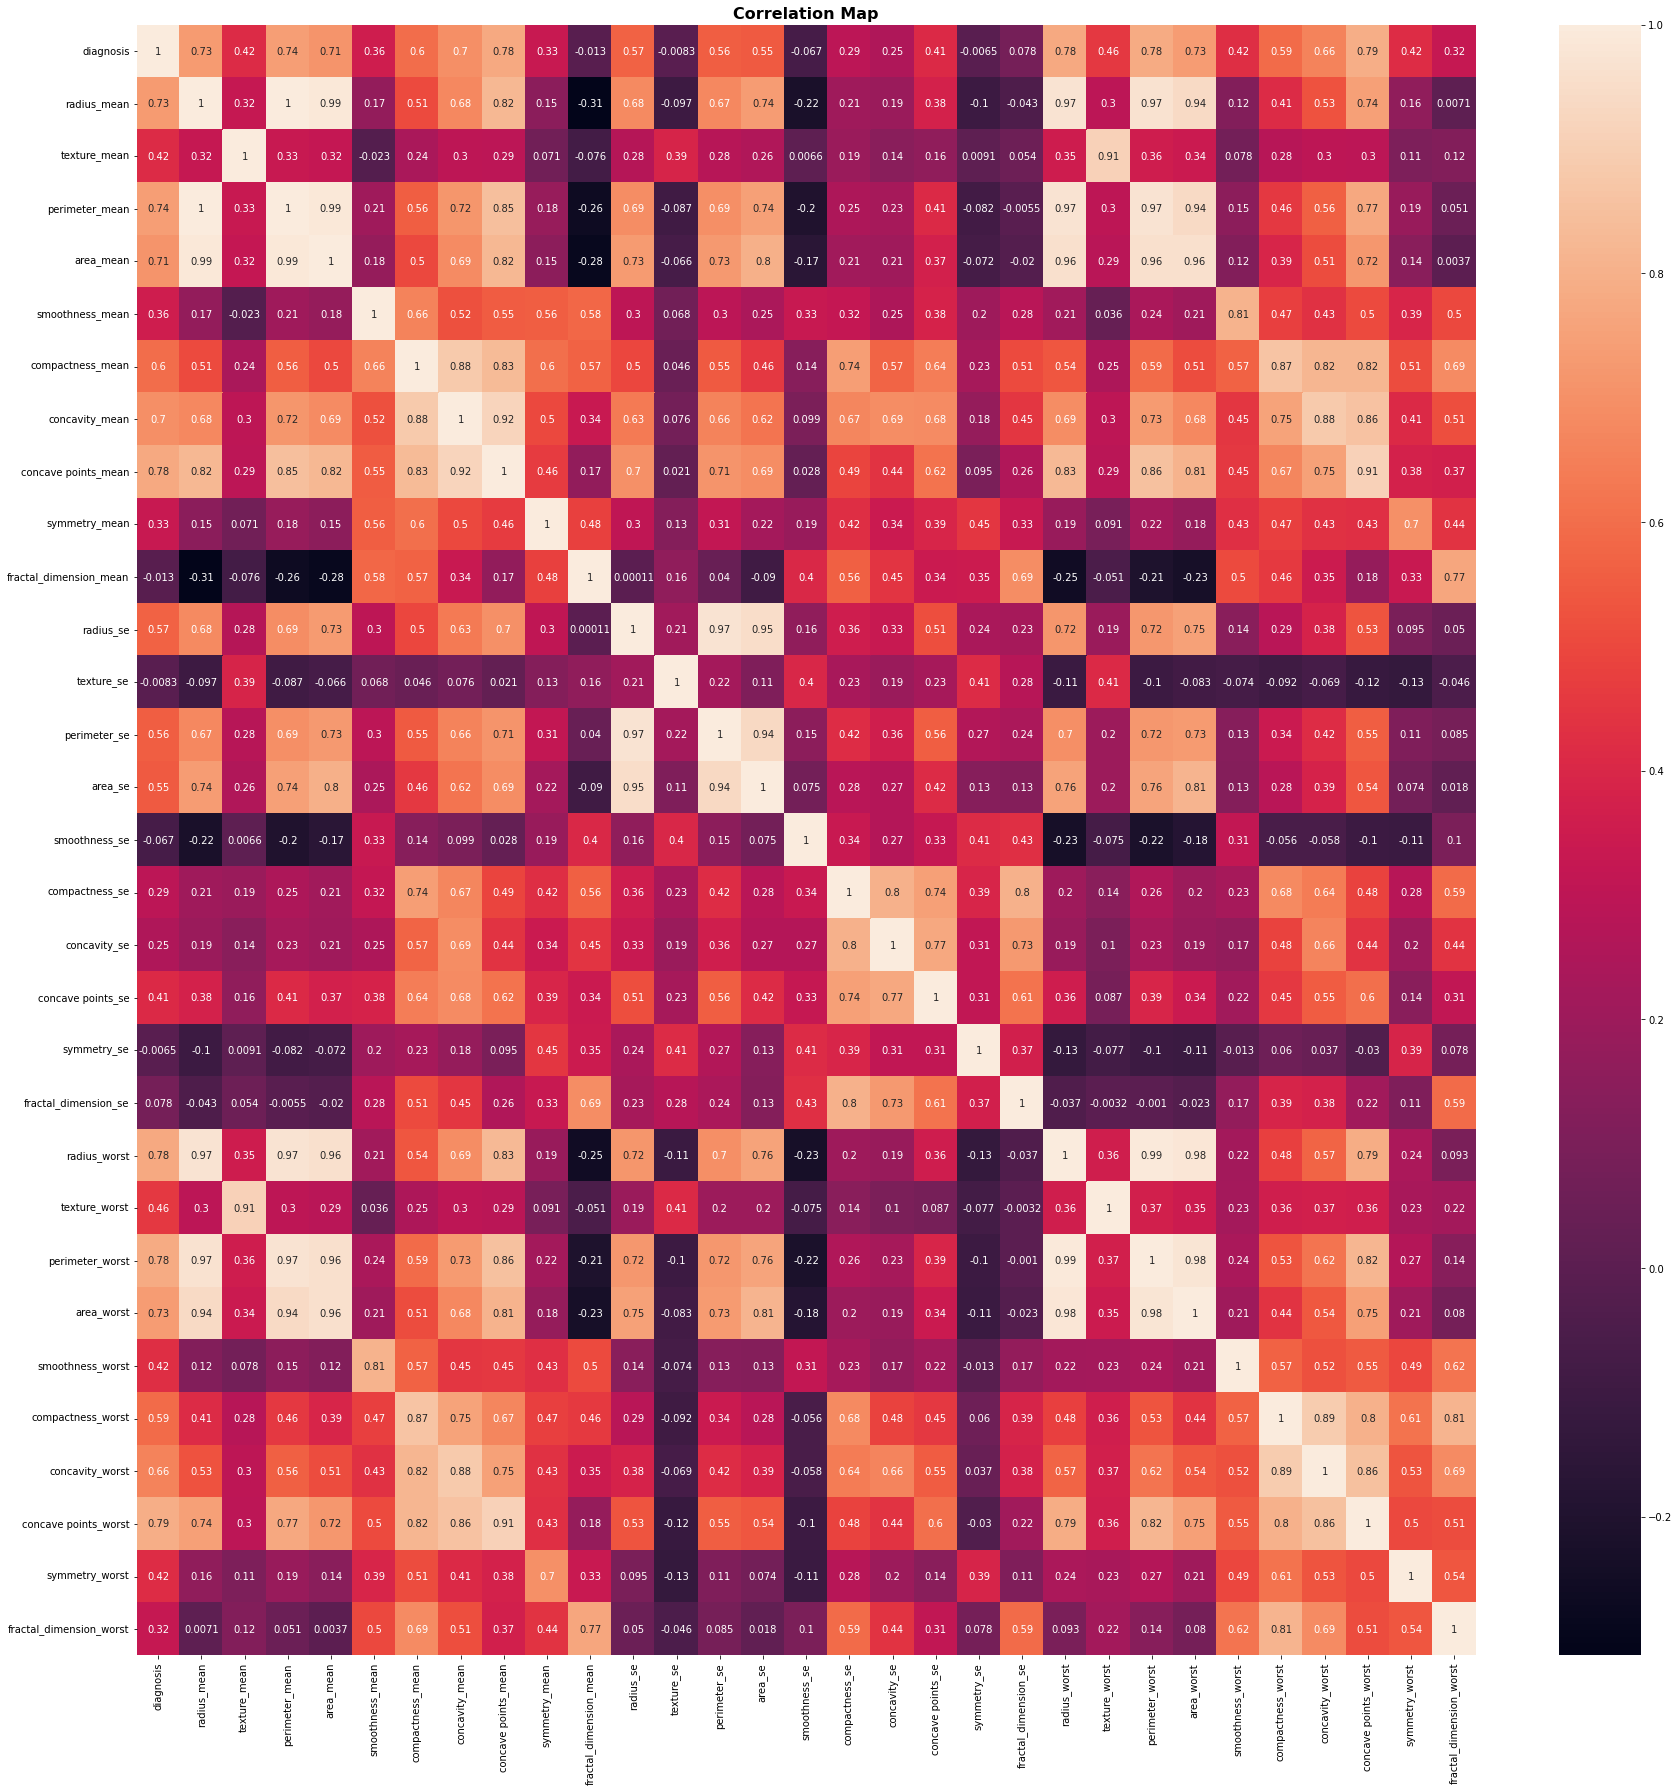

In [483]:
#Creiamo la heatmap di correlazione
plt.figure(figsize=(30,30))
sb.heatmap(df.corr(), annot = True)
plt.title("Correlation Map", fontweight = "bold", fontsize=16)

Come possiamo vedere, un grande numero di variabili indipendenti sono altamente correlate tra di loro, causando multicollinearità.

Facendo una breve analisi, abbiamo deciso di eliminare tutte le variabili etichettate con "worst" che identificano la media tra le 3 misurazioni più grandi (peggiori) di quella variabile, quindi costituendo un sottoinsieme delle colonne etichettate con "mean"

Inoltre abbiamo deciso di rimuovere le feature perimeter e area, poiché entrambe derivabili dal raggio (geometria).

In [484]:
corr_matrix = df.corr()
threshold = 0.1
filtre = np.abs(corr_matrix["diagnosis"]) <= threshold
to_delete = corr_matrix.columns[filtre].tolist()

print("Feature poco correlate con la variabile dipendente: ", to_delete)

df = df.drop(to_delete, axis = 1)

print("Features rimaste dopo la selezione:")

df.drop('diagnosis', axis = 1).columns

Feature poco correlate con la variabile dipendente:  ['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se']
Features rimaste dopo la selezione:


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se',
       'area_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [485]:
#Rimuoviamo tutte le colonne etichettate con "worst"
cols = ['radius_mean', 
        'texture_mean', 
        'perimeter_mean', 
        'area_mean', 
        'smoothness_mean', 
        'compactness_mean', 
        'concavity_mean',
        'concave points_mean', 
        'symmetry_mean']

df = df.drop(cols, axis=1)

#Rimuoviamo tutte le colonne che si riferiscono all'area e al perimetro

cols = ['perimeter_worst',
        'perimeter_se', 
        'area_worst', 
        'area_se']

df = df.drop(cols, axis=1)

Dopo aver selezionato le features migliori, analizziamo di nuovo la matrice di correlazione per capire se la collinearità è stata ridotta

Text(0.5, 1.0, 'Correlation Map')

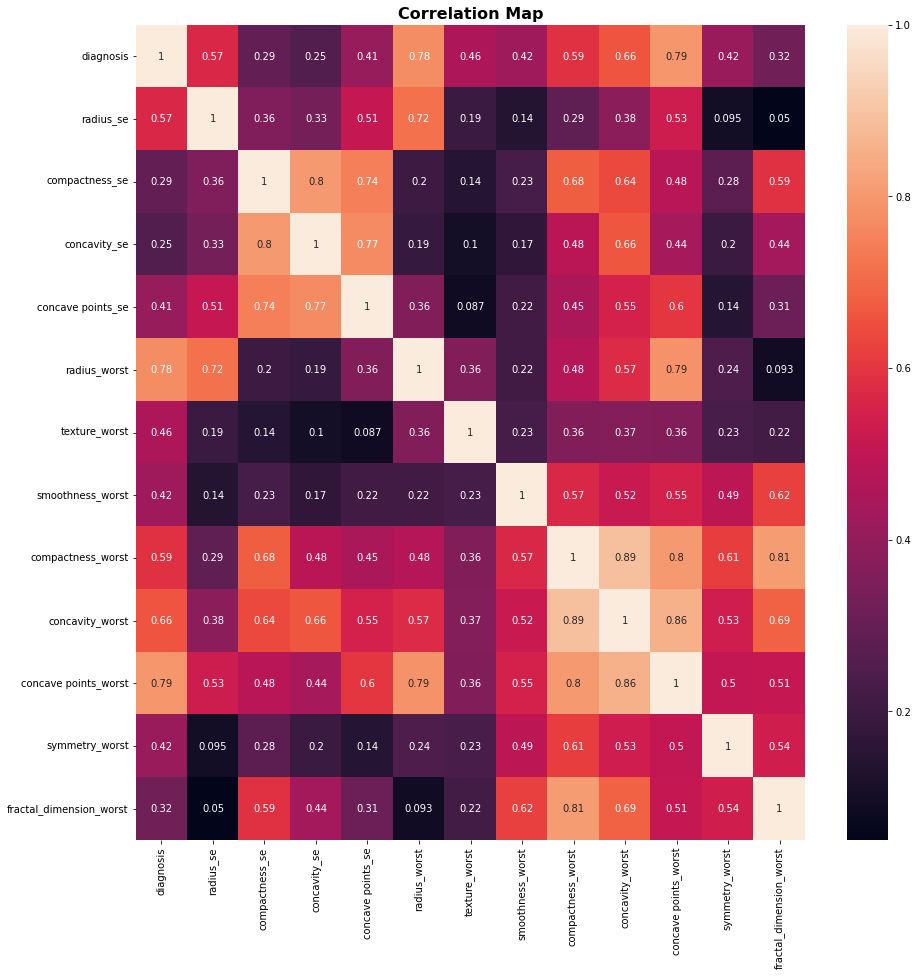

In [486]:
#Creiamo la heatmap di correlazione
plt.figure(figsize=(15,15))
sb.heatmap(df.corr(), annot = True)
plt.title("Correlation Map", fontweight = "bold", fontsize=16)

#3. Split Dataset

In [487]:
#Definizione delle variabili dipendenti e indipendenti

X = df.drop('diagnosis', axis = 1)

y = df['diagnosis']

In [488]:
#Split del dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (455, 12)
y_train dataset:  (455,)
X_test dataset:  (114, 12)
y_test dataset:  (114,)


0    357
1    212
Name: diagnosis, dtype: int64

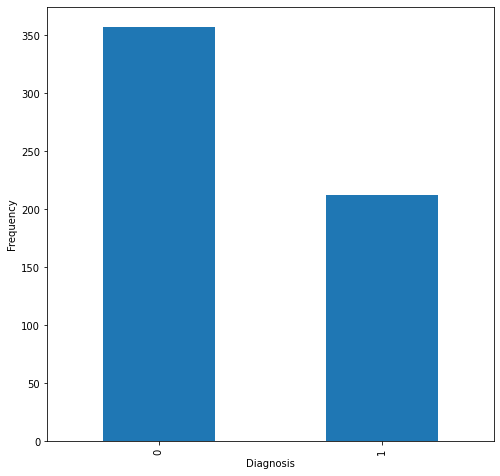

In [489]:
#Distribuzione della variabile dipendente
plt.figure(figsize=(8,8))
pd.value_counts(df['diagnosis']).plot.bar()
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
df['diagnosis'].value_counts()

#4. Data Scaling

In [490]:
#Verifichiamo se le variabili seguono una distribuzione Gaussiana
from scipy.stats import shapiro
for i in df.columns:
  print(f'{i}: {"Not Gaussian" if shapiro(df[i])[1]<0.05 else "Gaussian"}  {shapiro(df[i])}')

diagnosis: Not Gaussian  (0.6124988794326782, 8.905348673867872e-34)
radius_se: Not Gaussian  (0.7455540895462036, 1.2245553698549864e-28)
compactness_se: Not Gaussian  (0.8368780612945557, 1.0828804875356465e-23)
concavity_se: Not Gaussian  (0.6720700263977051, 1.101693524093482e-31)
concave points_se: Not Gaussian  (0.9197062253952026, 7.82604378738137e-17)
radius_worst: Not Gaussian  (0.9134925603866577, 1.7043174747122154e-17)
texture_worst: Not Gaussian  (0.9825620651245117, 2.564881469879765e-06)
smoothness_worst: Not Gaussian  (0.9886201024055481, 0.0002097362739732489)
compactness_worst: Not Gaussian  (0.8910645842552185, 1.2475981315634304e-19)
concavity_worst: Not Gaussian  (0.9175271391868591, 4.542876255013473e-17)
concave points_worst: Not Gaussian  (0.9648364186286926, 1.9859026922919298e-10)
symmetry_worst: Not Gaussian  (0.9161444306373596, 3.234117707276973e-17)
fractal_dimension_worst: Not Gaussian  (0.8895459175109863, 9.195529701560753e-20)


Siccome le variabili non seguono una distribuzione Gaussiana, decidiamo di effettuare una normalizzazione con con l'ausilio di MinMaxScaler

In [491]:
#Normalizzazione
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#5. Feature Engineering

Text(0.5, 1.0, 'Correlation Map')

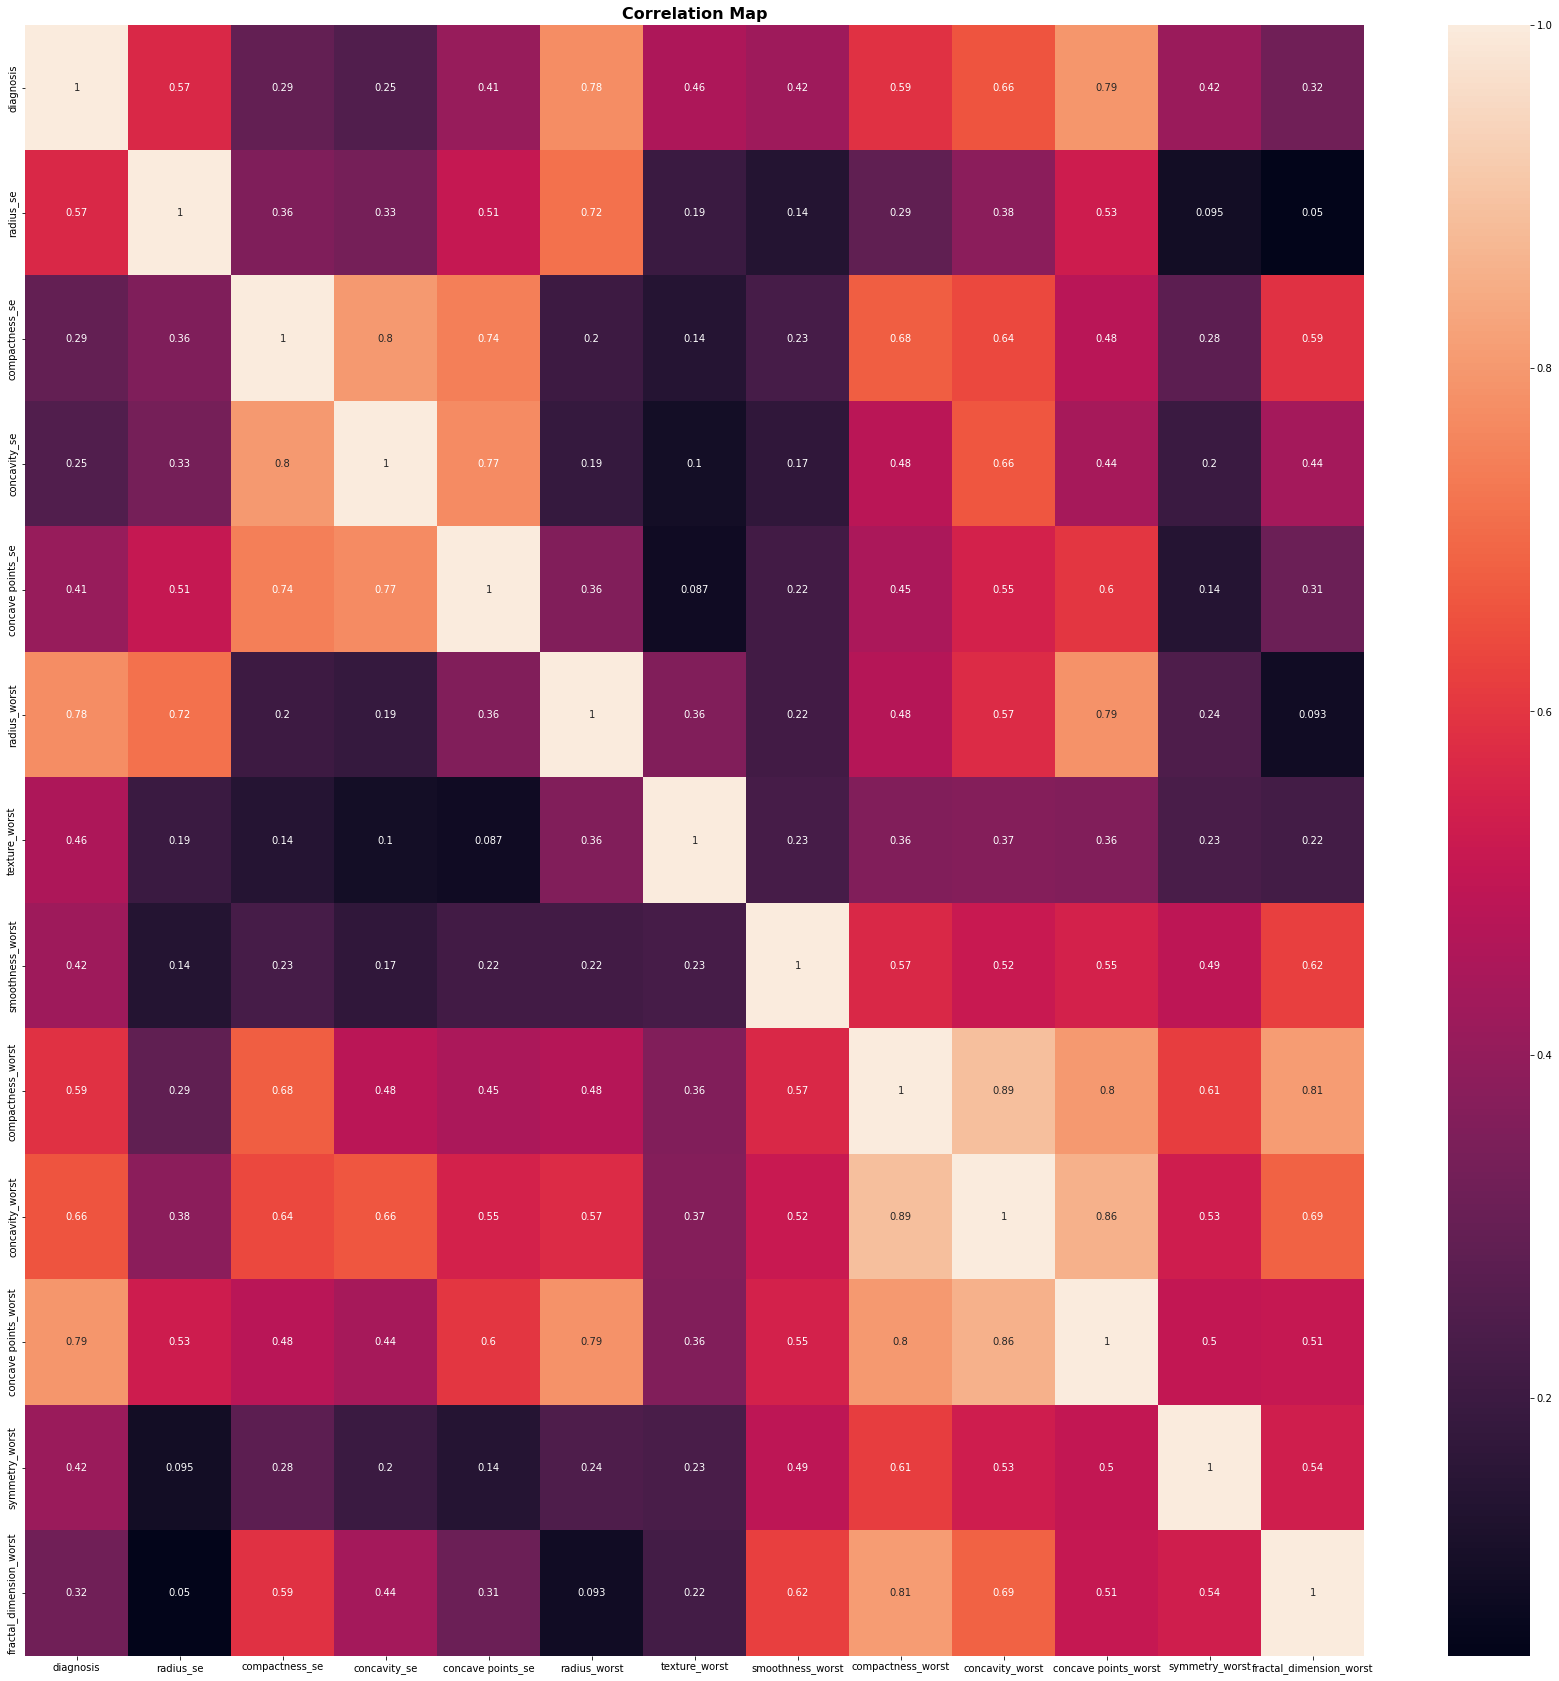

In [492]:
#Creiamo la heatmap di correlazione
plt.figure(figsize=(30,30))
sb.heatmap(df.corr(), annot = True)
plt.title("Correlation Map", fontweight = "bold", fontsize=16)

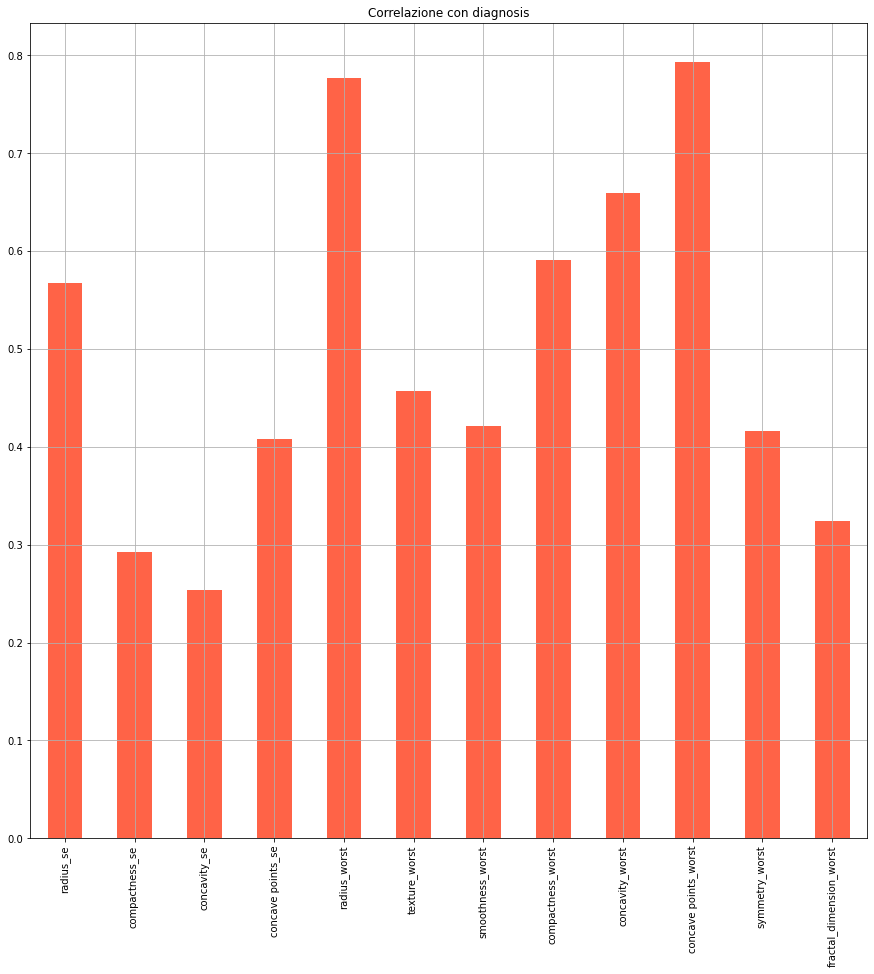

In [493]:
#Creaiamo un dataframe senza il target
df_without_target = df.drop('diagnosis', axis=1)

#Otteniamo la correlazione a coppie con il target
df_with_correlation = df_without_target.corrwith(df.diagnosis)


#Creiamo un istogramma con la correlazione dei dati con il nostro target (diagnosis)
df_with_correlation.plot(kind='bar', grid=True, figsize=(15, 15), title="Correlazione con diagnosis",color="tomato");

In [494]:
#Feature selection supervisionata
#fs = SelectKBest(score_func=r_regression,k=26)
#fs.fit_transform(X_train, y_train)

#X_train = fs.transform(X_train)
#X_test = fs.transform(X_test)
#print(X_train.shape)


#X.columns[fs.get_support(indices=True)]

#X.columns[fs.get_support(indices=True)].tolist()

#6. Costruzione dei modelli

##6.1 Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


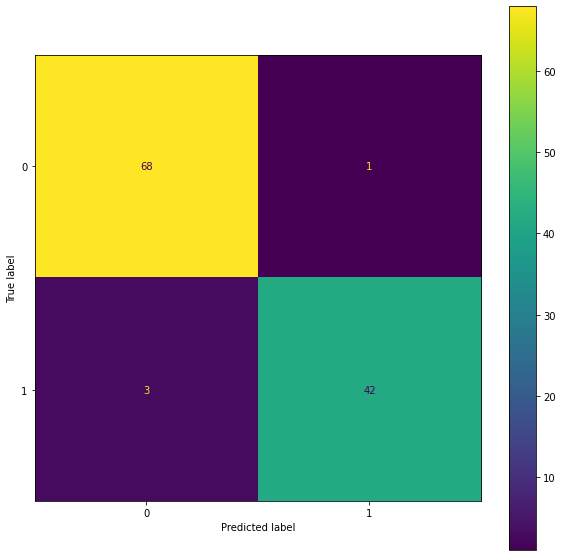

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        69
           1       0.98      0.93      0.95        45

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 0.9649122807017544


In [501]:
logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

y_pred = logisticRegr.predict(X_test)

labels = np.unique(y_test)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logisticRegr, X_test, y_test, ax=ax)  

plt.show()

print(classification_report(y_test, y_pred))

print("Accuracy:",accuracy_score(y_test, y_pred))

##6.2 Naive-Bayes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


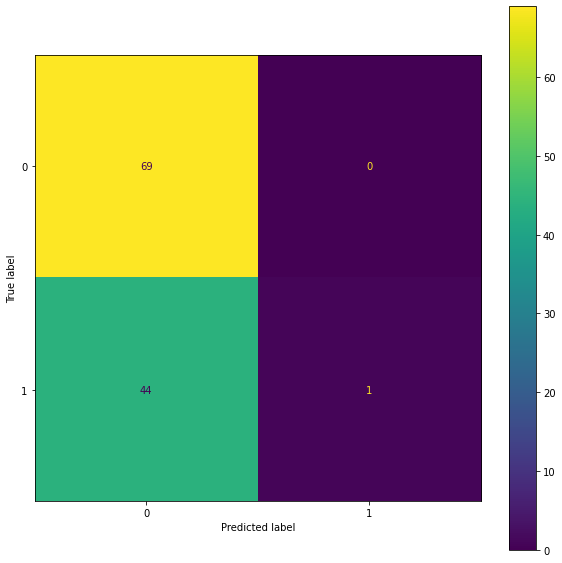

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        69
           1       1.00      0.02      0.04        45

    accuracy                           0.61       114
   macro avg       0.81      0.51      0.40       114
weighted avg       0.76      0.61      0.48       114

Accuracy: 0.6140350877192983


In [496]:
NB = BernoulliNB()

NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

labels = np.unique(y_test)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(NB, X_test, y_test, ax=ax)  

plt.show()

print(classification_report(y_test, y_pred))

print("Accuracy:",accuracy_score(y_test, y_pred))

##6.3 Decision Tree

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


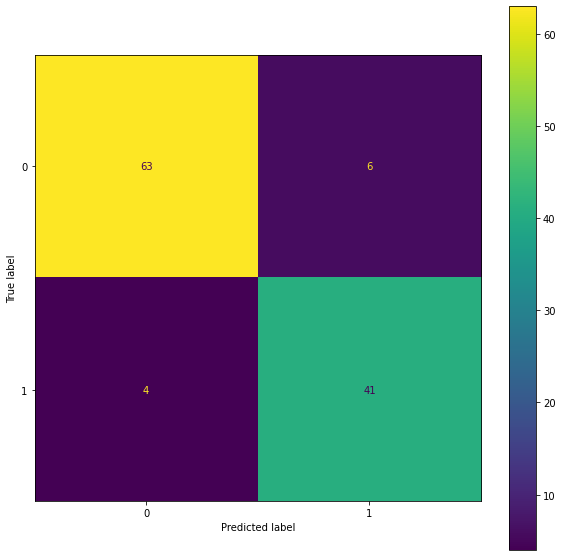

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        69
           1       1.00      0.02      0.04        45

    accuracy                           0.61       114
   macro avg       0.81      0.51      0.40       114
weighted avg       0.76      0.61      0.48       114

Accuracy: 0.6140350877192983


In [497]:
DecisionTree = DecisionTreeClassifier()

DecisionTree.fit(X_train, y_train)

y_pred = NB.predict(X_test)

labels = np.unique(y_test)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(DecisionTree, X_test, y_test, ax=ax)  

plt.show()

print(classification_report(y_test, y_pred))

print("Accuracy:",accuracy_score(y_test, y_pred))